In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
file_path = "D:\data science training\House_Rent_Dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows
print("First five rows of the dataset:")
print(df.head())

# Check data types, missing values, and basic info
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())


First five rows of the dataset:
   Posted On  BHK   Rent  Size            Floor    Area Type  \
0  18/5/2022    2  10000  1100  Ground out of 2   Super Area   
1  13/5/2022    2  20000   800       1 out of 3   Super Area   
2  16/5/2022    2  17000  1000       1 out of 3   Super Area   
3   4/7/2022    2  10000   800       1 out of 2   Super Area   
4   9/5/2022    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3 

In [3]:
# Transform 'posted on ' to numerical (date since posted)
df['Posted On'] = pd.to_datetime(df['Posted On'])
df['Days Since Posted'] = (df['Posted On'] - df['Posted On'].min()).dt.days

# Transform 'floor' into numerical columns
def process_floor(floor_value):
    try:
        floor_number, total_floor = floor_value.split(" out of ")
        floor_number = int(floor_number) if floor_number.isnumeric() else 0   # handle case like ground floor
        total_floor = int(total_floor) if total_floor.isnumeric() else 0
        return floor_number, total_floor
    except:
        return 0, 0
    
floor_data = df['Floor'].apply(process_floor)
df['Floor_Number'] = floor_data.apply(lambda x: x[0])         # Extract floor number
df['Total_Floor'] = floor_data.apply(lambda x: x[1])          # Extract total floor

#Drop original 'Posted on' and 'Floor' column 
df = df.drop(columns=['Posted On', 'Floor'])

# Dispay updated df
print(df.head())

   BHK   Rent  Size    Area Type             Area Locality     City  \
0    2  10000  1100   Super Area                    Bandel  Kolkata   
1    2  20000   800   Super Area  Phool Bagan, Kankurgachi  Kolkata   
2    2  17000  1000   Super Area   Salt Lake City Sector 2  Kolkata   
3    2  10000   800   Super Area               Dumdum Park  Kolkata   
4    2   7500   850  Carpet Area             South Dum Dum  Kolkata   

  Furnishing Status  Tenant Preferred  Bathroom Point of Contact  \
0       Unfurnished  Bachelors/Family         2    Contact Owner   
1    Semi-Furnished  Bachelors/Family         1    Contact Owner   
2    Semi-Furnished  Bachelors/Family         1    Contact Owner   
3       Unfurnished  Bachelors/Family         1    Contact Owner   
4       Unfurnished         Bachelors         1    Contact Owner   

   Days Since Posted  Floor_Number  Total_Floor  
0                 35             0            2  
1                 30             1            3  
2             

C:\Users\Admin\AppData\Local\Temp\ipykernel_19552\516960690.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Posted On'] = pd.to_datetime(df['Posted On'])


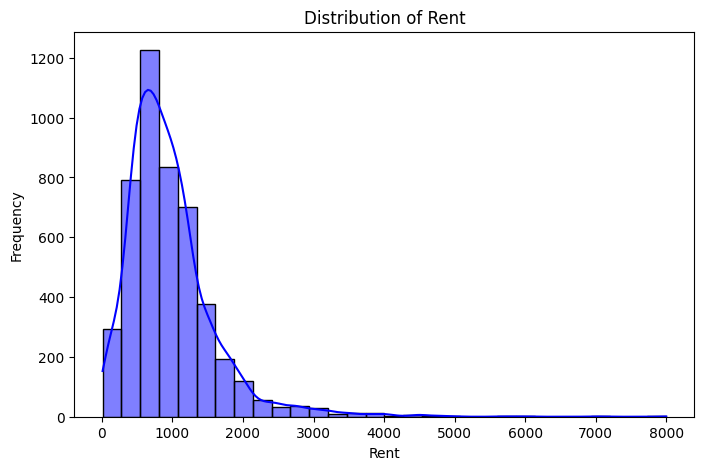

In [4]:
# Distribution of the target variable (e.g., 'Rent')
plt.figure(figsize=(8, 5))
sns.histplot(df['Size'], kde=True, color='blue', bins=30)  # Replace 'Rent' with your target column
plt.title('Distribution of Rent')
plt.xlabel('Rent')
plt.ylabel('Frequency')
plt.show()


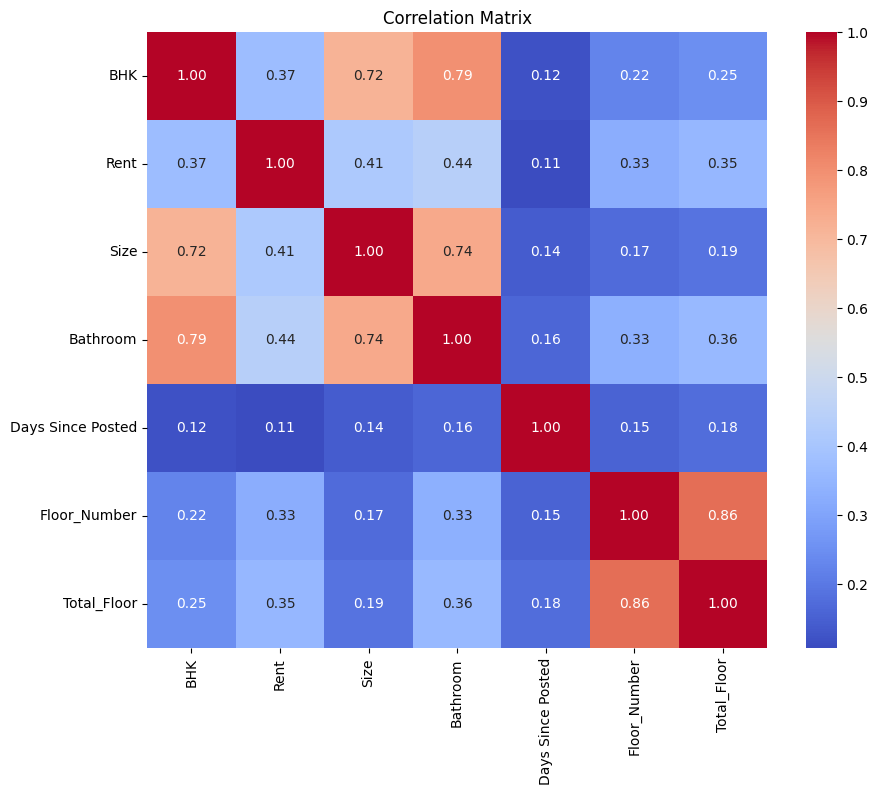

In [ ]:
# Correlation heatmap for numeric variables
numeric_df = df.select_dtypes(include=[np.number])  # Select numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [6]:
# Drop rows with missing values
df.dropna(inplace=True)

In [7]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Combine rare categories into 'Other'
for col in categorical_columns:
    top_categories = df[col].value_counts().index[:10]  # Keep only top 10 categories
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')

# Apply one-hot encoding for remaining categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [8]:
# Compute correlation with the target
correlation_with_target = df.corr()['Rent'].abs().sort_values(ascending=False)
selected_features = correlation_with_target[correlation_with_target > 0.1].index  # Threshold for selection
X = df[selected_features.drop('Rent')]  # Drop the target variable from features
y = df['Rent']

print(f"Reduced Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")


Reduced Features Shape: (4746, 12)
Target Shape: (4746,)


In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (3796, 12), (3796,)
Testing set: (950, 12), (950,)


In [10]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf_model.predict(X_test)


In [11]:
# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
lr_pred = lr_model.predict(X_test)


In [12]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    print("-" * 50)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

In [13]:
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

Random Forest Performance:
Mean Absolute Error (MAE): 12723.583451629072
Mean Squared Error (MSE): 1375289301.8400185
Root Mean Squared Error (RMSE): 37084.89317552389
R-squared (R2): 0.6549165080104545
--------------------------------------------------


In [14]:
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")

Linear Regression Performance:
Mean Absolute Error (MAE): 21888.172339685072
Mean Squared Error (MSE): 1933360121.0139232
Root Mean Squared Error (RMSE): 43969.99114184495
R-squared (R2): 0.5148870416281157
--------------------------------------------------


In [15]:
# Compare the models based on R2 and RMSE
if rf_metrics['R2'] > lr_metrics['R2']:
    print("Random Forest is the best model based on R-squared.")
else:
    print("Linear Regression is the best model based on R-squared.")

if rf_metrics['RMSE'] < lr_metrics['RMSE']:
    print("Random Forest is the best model based on RMSE.")
else:
    print("Linear Regression is the best model based on RMSE.")

Random Forest is the best model based on R-squared.
Random Forest is the best model based on RMSE.


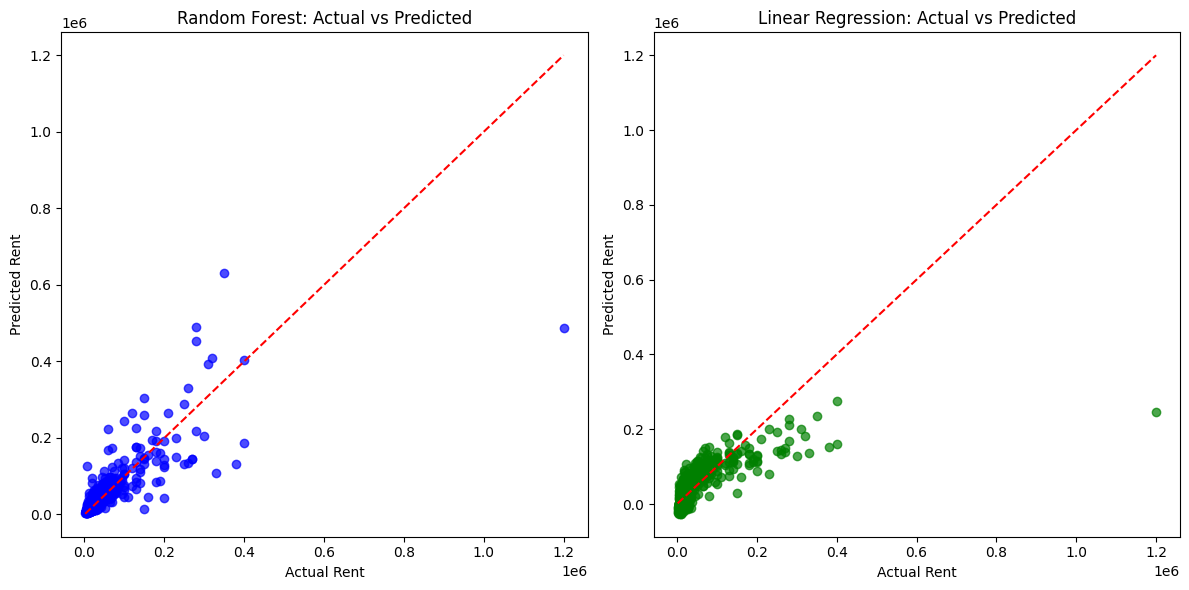

In [16]:
# Predictions from both models
rf_pred = rf_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

plt.figure(figsize=(12, 6))

# Plot for Random Forest
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.scatter(y_test, rf_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')

# Plot for Linear Regression
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.scatter(y_test, lr_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')

# Display the plots
plt.tight_layout()
plt.show()